# Lag and Autocorrelation

Now that you have some familiarity with time series data, we'll dive a little deeper into the theory. We present the concepts of <i>lag</i> and <i>autocorrelation</i> before talking about more advanced forecasting algorithms.

## What You Will Accomplish in This Notebook

In particular you will:
<ul>
    <li>Be introduced to the concept of lag,</li>
    <li>See how lag plots can help us identify seasonality,</li>
    <li>Learn what autocorrelation is,</li>
    <li>Make autocorrelation plots also known as correlograms.</li>
</ul>

Let's start by importing our usual packages.

In [1]:
# import the packages we'll use
from datetime import datetime

## For data handling
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns

## This sets the plot style
## to have a grid on a white background
sns.set_style("whitegrid")

As with regression let's say we're interested in a target, $y$, and that the value of the target at time $t$ is denoted $y_t$.

## He's Lagging!

Anyone that's played video games online has heard the term <i>lag</i> before. In gaming it refers to delay in what occurs on your screen versus when it actually occured. 

In time series data it references essentially the same thing. A lag of $0$ means that for time $t$ we're looking at $y_t$. A lag of $k$ means that for time $t$ we're looking at $y_{t-k}$.

### Lag Plots

One way to use lag to learn about the time series data is to look at what are called <i>lag plots</i>. In these plots for lag $k$ we plot $y_t$ vs $y_{t-k}$. You typically make a series of these plots for different lags to try and identify any patterns related to the temporal nature of the data.

Let's see an example using quarterly australian beer production data from 1992 Q1 to 2010 Q2.

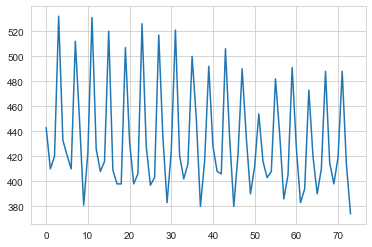

In [2]:
# read in ausbeer
# adding in parse_dates, saves us a line of coding
ausbeer = pd.read_csv("ausbeer.csv")

plt.plot(ausbeer)

plt.show()

In [4]:
ausbeer_train = ausbeer.iloc[:-15,].copy()
ausbeer_test = ausbeer.drop(ausbeer_train.index).copy()

In [5]:
# This function makes a lag_df 
# for easy plotting
def make_lag_df(df,feature,lag):
    lag_df = df.copy()
    lag_df[feature + '_lag'] = np.nan
    
    lag_df.loc[lag:,feature + '_lag'] = lag_df.loc[0:len(lag_df)-(lag+1),feature].values
    return lag_df

In [6]:
# A function to make our plotting easier
def plot_lag(df,feature,lag,ax=None):
    df = make_lag_df(df,feature,lag).dropna()
    if ax:
        ax.scatter(df[feature+'_lag'],df[feature])

        ax.plot(np.linspace(350,550,10),
                np.linspace(350,550,10),
               'k--', alpha = .6)

        ax.set_title("lag = " + str(lag),fontsize=12)
    else:
        plt.scatter(df[feature+'_lag'],df[feature])

        plt.plot(np.linspace(350,550,10),
                np.linspace(350,550,10),
               'k--', alpha = .6)

        plt.show()

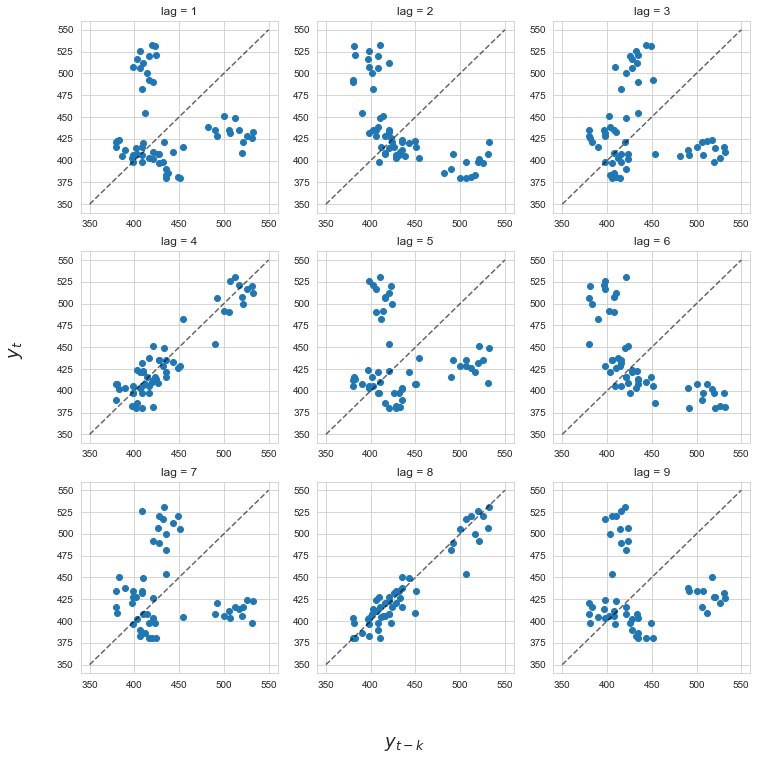

In [7]:
# we'll make lag plot for lag = 1 to 9

fig,ax = plt.subplots(3,3,
                      figsize = (12,12))

for i in range(1,10):
    plot_lag(ausbeer_train,'production',i,ax[(i-1)//3, (i-1)%3])

    
fig.text(0.5, 0.04, '$y_{t-k}$', ha='center',fontsize=18)
fig.text(0.04, 0.5, '$y_t$', va='center', rotation='vertical',fontsize=18)

plt.show()

Looking at these sorts of plots can allow us to identify patterns like seasonality. For example, we see that at lags $4$ and $8$ the points seem to surround the dotted line. This line is $y_t = y_{t-k}$. This means that every $4$ or $8$ time steps the values are quite similar. This suggests seasonality in the data with a frequency of $4$ time steps. Since the timesteps are in quarters, our beer data seemingly has a frequency of $1$ business year.

## Questions

<br>
<br>
<br>
<br>

## End Questions

## Autocorrelation

Remember back during regression we defined Pearson's correlation, $\rho$, to measure the strength of the linear relationship between $X$ and $y$.

We can do the same thing with time series data, except this time it is called autocorrelation. We can measure the strength of the linear relationship between $y_t$ and $y_{t-k}$ with the following formula:
$$
r_k = \frac{\sum_{t = k+1}^T \left( y_t - \overline{y}  \right)  \left( y_{t-k} - \overline{y}  \right)}{\sum_{t=1}^T \left( y_t - \overline{y}  \right)^2},
$$
where $T$ is the length of the time series, and $\overline{y} = \frac{1}{T} \sum_{t=1}^T y_t$.

We can calculate these for the australian beer production data like so.

In [8]:
def get_autocorr(df,feature,lag):
    df = make_lag_df(df,feature,lag)
    mean_y = df[feature].mean()
    
    
    
    y_ts = df[feature].values
    y_lags = df.dropna()[feature + '_lag'].values
    
    numerator = np.sum((y_ts[lag:] - mean_y)*(y_lags - mean_y))
    denom = np.sum(np.power(y_ts - mean_y,2))
    
    return numerator/denom

In [9]:
# for lag = 1 to 9
lags = np.arange(1,9,1)

print(lags)
print([get_autocorr(ausbeer_train,'production',lag) for lag in lags])

[1 2 3 4 5 6 7 8]
[-0.10812745208218705, -0.6508531142234968, -0.09117248196680992, 0.857922330418269, -0.07795374368234877, -0.6248048597783807, -0.08842360485646308, 0.8353821387192539]


### Autocorrelation Plots or Correlograms

Reading tables can be make it hard to understand the pattern, so an alternative approach is to plot the autocorrlations, this is known as a <i>correlogram</i>.

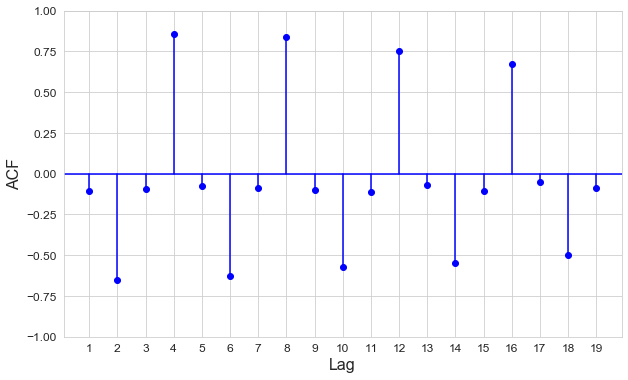

In [10]:
# make a figure
plt.figure(figsize=(10,6))

plt.ylim(-1,1)


plt.axhline(y=0, xmin=0, xmax=20, color = "blue")
plt.scatter(np.arange(1,20,1), 
           [get_autocorr(ausbeer_train,'production',lag) for lag in np.arange(1,20,1)],
           c='b')

for i in np.arange(1,20,1):
    plt.plot(i*np.ones(2),[0,get_autocorr(ausbeer_train,'production',i)],'b')

plt.xlabel("Lag", fontsize=16)
plt.ylabel("ACF", fontsize=16)

plt.xticks(np.arange(1,20,1), fontsize=12)
plt.yticks(fontsize=12)

plt.show()

On the plot `ACF` refers to the autocorrelation function.

For the australian beer data we see strong positive autocorrelation every 4 units, this is evidence of the seasonality having a frequency of $4$ quarters. 

The negative autocorrelation at lags $2$ $6$ $10$ $14$ and $18$ are also evidence of seasonality, the negative autocorrelation just shows how shifting the data by $2$ puts the $y_t$ data and the $y_{t-2}$ data in <i>antiphase</i>. This is best defined with an image.

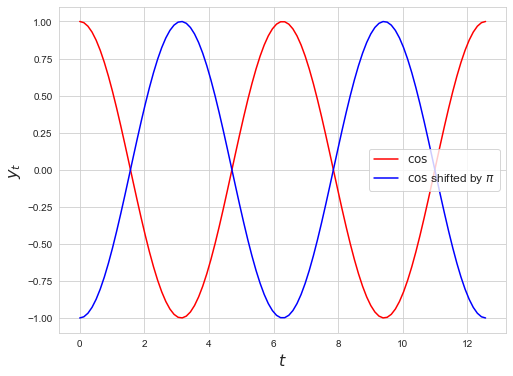

In [11]:
plt.figure(figsize=(8,6))

plt.plot(np.linspace(0,4*np.pi,100),
            np.cos(np.linspace(0,4*np.pi,100)),
            'r', label="$\cos$")

plt.plot(np.linspace(0,4*np.pi,100),
            np.cos(np.pi + np.linspace(0,4*np.pi,100)),
            'b', label="$\cos$ shifted by $\pi$")

plt.xlabel("$t$",fontsize=16)
plt.ylabel("$y_t$",fontsize=16)


plt.legend(fontsize=12)
plt.show()

AFC plots can also help us identify when the time series is trending upwards or downwards as you see in the next breakout session.

## Practice

Try to identify patterns in the measles time series data through lag plots and the autocorrelation function.

Only use data prior to 1963 and use the years prior to 1959 as the training data.

In [12]:
## Code here
measles = pd.read_csv("measles.csv", parse_dates = ['month'])

measles_copy = measles.loc[measles.month < datetime(1963,1,1),].copy()
measles_train = measles_copy.loc[measles.month < datetime(1959,1,1),]
measles_test = measles_copy.drop(measles_train.index)

In [16]:
measles.head()

,month,cases
0,1928-01-01,609
1,1928-02-01,1516
2,1928-03-01,4952
3,1928-04-01,7466
4,1928-05-01,11155


In [38]:
## Code here

MAX_LAG = 72 
num_lags = list(range(MAX_LAG))
auto_corr = [0]*(MAX_LAG)
N = len(measles)
for lag in range(MAX_LAG): 
    s1 = measles['cases'].iloc[lag:] 
    s2 = measles['cases'].iloc[:N-lag]     
    auto_corr[lag] = (np.corrcoef(s1,s2)[0,1])

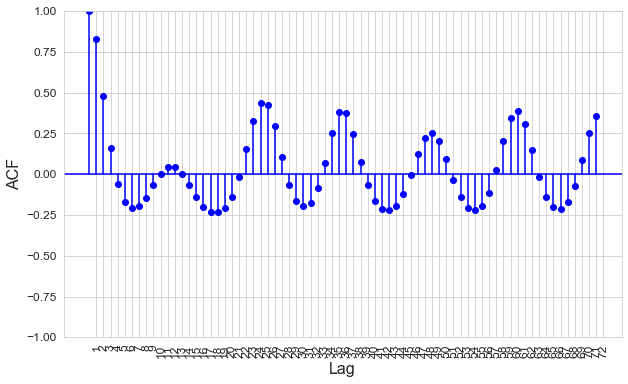

In [42]:
plt.figure(figsize=(10,6))

plt.ylim(-1,1)


plt.axhline(y=0, xmin=0, xmax=MAX_LAG+1, color = "blue")
plt.scatter(num_lags, 
           auto_corr,
           c='b')

for i in np.arange(MAX_LAG):
    plt.plot([i,i],[0,auto_corr[i]],'b')

plt.xlabel("Lag", fontsize=16)
plt.ylabel("ACF", fontsize=16)

plt.xticks(np.arange(1,MAX_LAG+1,1), fontsize=12, rotation=90)
plt.yticks(fontsize=12)


plt.show()

What did you observe? Did you find any seasonality or increasing/decreasing trend? How does it compare to what you see when you plot the time series?









## Practice Cont. - An Example with Trend

Read in the following data on Australian electricity production from 1980 to 1995. Don't worry about the training test split here.

In [ ]:
elec = pd.read_csv("elec.csv", parse_dates=['month'])

In [ ]:
elec.plot(x="month",y="production", figsize=(8,6))

plt.show()

In [ ]:
# Code here











Make an ACF plot for these data, make your lag go out to $100$.

In [ ]:
## Code here










We know from the above plot that there is a clear increasing trend. In this sort of scenario we expect to see our ACF plot be large and then slowly decreases.

Next run this block of code that flips the order of our data.

In [ ]:
flipped = elec.copy()

In [ ]:
flipped['production'] = elec.sort_values('month',ascending=False).production.values

In [ ]:
flipped.plot(x="month",y="production")

plt.show()

Make an ACF plot for the flipped data. What do you expect to happen? What actually happened?

In [ ]:
# Code Here










In [ ]:
## Code here











In [ ]:
## Code here







In [ ]:
## Code here









In [ ]:
## Code here









That's the end of this notebook. We'll continue learning about how you can look at test errors and cross validation for time series data in the next notebook!

### References

Chapters 2 and 3 of <a href="https://otexts.com/fpp2/">Forecasting: Principles and Practice</a>, by Rob J Hyndman and George Athanasopoulos.